# PPO Algorithm

This code performs PPO on the Patrolling Zoo environment.

In [7]:
%load_ext autoreload
%autoreload 2

import torch
from patrolling_zoo.patrolling_zoo_v0 import parallel_env, PatrolGraph
from algorithm.ppo import PPO

# set process priority low
import psutil
import os
if os.name == 'nt':
    psutil.Process(os.getpid()).nice(psutil.BELOW_NORMAL_PRIORITY_CLASS)
else:
    psutil.Process(os.getpid()).nice(10)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Configuration

In [8]:
MAX_CYCLES = 50

""" ENV SETUP """
patrolGraph = PatrolGraph("patrolling_zoo/env/4nodes.graph")
env = parallel_env(patrolGraph, 1,
    require_explicit_visit=True,
    speed= 5,
    alpha=1,
    max_cycles=MAX_CYCLES,
    reward_shift = 0.3
)

"""ALGO PARAMS"""
algo = PPO(
    env = env,
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu"),
    ent_coef = 0.1,
    vf_coef = 0.1,
    clip_coef = 0.1,
    gamma = 0.99,
    lr = 1e-4,
    batch_size = 1,
    stack_size = 4,
    frame_size = (64, 64),
    max_cycles = MAX_CYCLES,
    total_episodes = 100
)

# Training

In [9]:
stats = algo.train(seed=42)

Training episode 0
Episodic Return: -133.65362548828125
Episode Length: 49

Training episode 1
Episodic Return: -136.84458923339844
Episode Length: 49

Training episode 2
Episodic Return: -133.43899536132812
Episode Length: 49

Training episode 3
Episodic Return: -137.4980926513672
Episode Length: 49

Training episode 4
Episodic Return: -137.90248107910156
Episode Length: 49

Training episode 5
Episodic Return: -137.51058959960938
Episode Length: 49

Training episode 6
Episodic Return: -137.6162109375
Episode Length: 49

Training episode 7
Episodic Return: -135.06398010253906
Episode Length: 49

Training episode 8
Episodic Return: -139.86703491210938
Episode Length: 49

Training episode 9
Episodic Return: -133.15975952148438
Episode Length: 49

Training episode 10
Episodic Return: -134.50753784179688
Episode Length: 49

Training episode 11
Episodic Return: -133.85140991210938
Episode Length: 49

Training episode 12
Episodic Return: -135.6357879638672
Episode Length: 49

Training episod

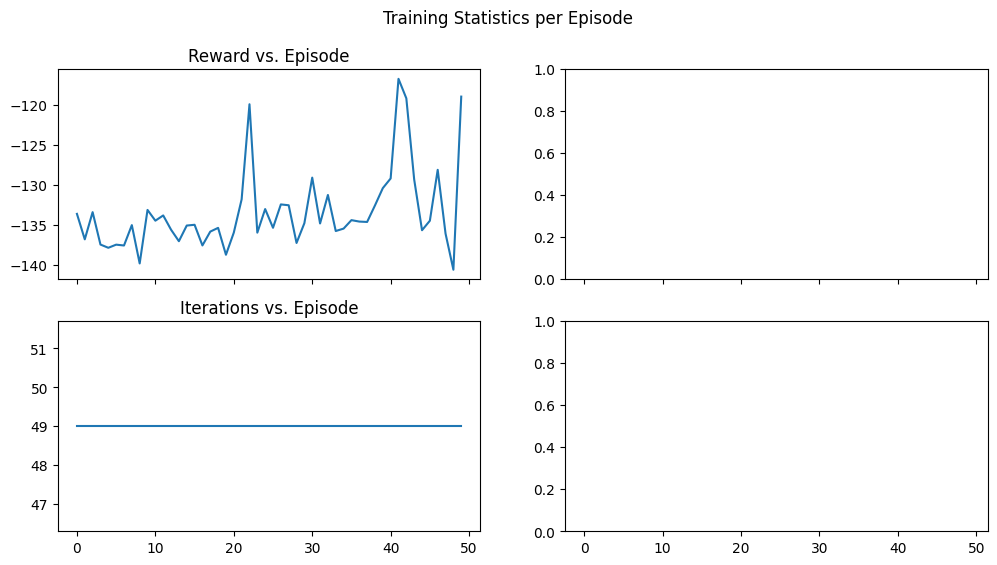

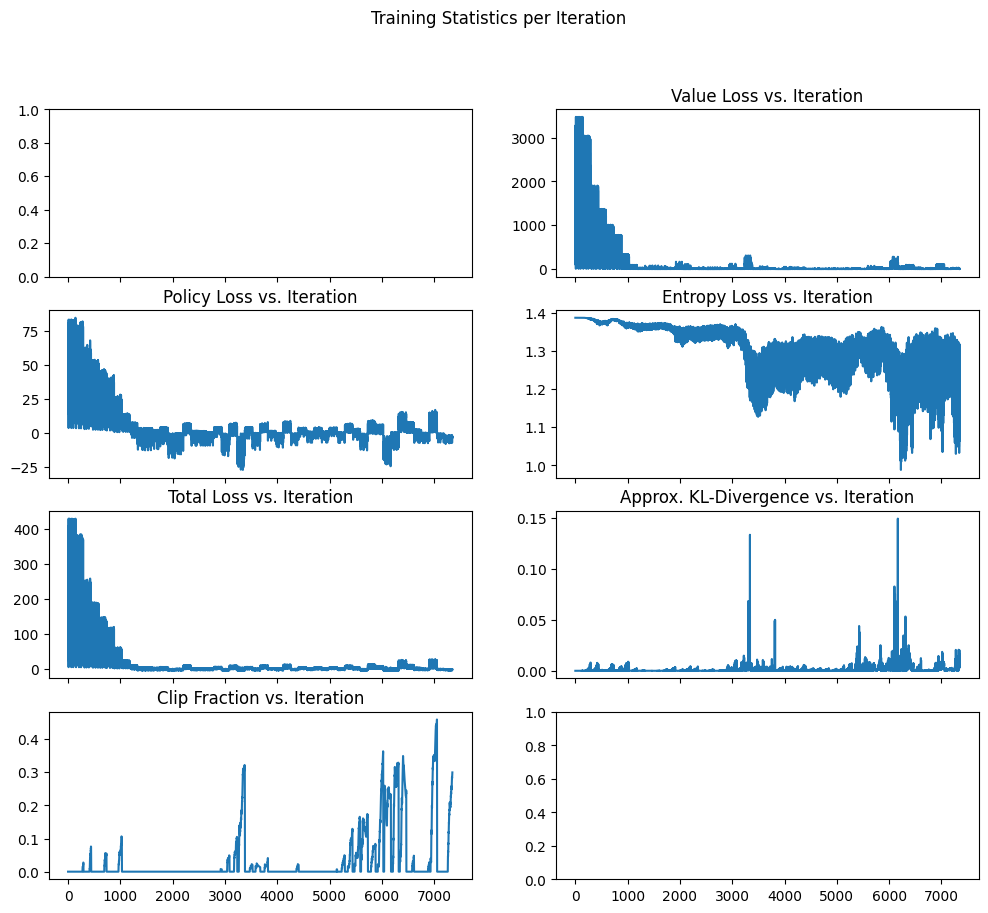

In [10]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(2, 2, sharex=True, figsize=(12, 6))
fig.suptitle("Training Statistics per Episode")

ax[0, 0].set_title("Reward vs. Episode")
ax[0, 0].plot(stats["episodic_return"])

ax[1, 0].set_title("Iterations vs. Episode")
ax[1, 0].plot(stats["episodic_length"])

plt.show()


fig, ax = plt.subplots(4, 2, sharex=True, figsize=(12, 10))
fig.suptitle("Training Statistics per Iteration")

ax[0, 1].set_title("Value Loss vs. Iteration")
ax[0, 1].plot(stats["value_loss"], label="value_loss")
# ax[0, 1].legend()

ax[1, 0].set_title("Policy Loss vs. Iteration")
ax[1, 0].plot(stats["policy_loss"], label="policy_loss")
# ax[1, 0].legend()

ax[1, 1].set_title("Entropy Loss vs. Iteration")
ax[1, 1].plot(stats["entropy_loss"], label="entropy_loss")
# ax[1, 1].legend()

ax[2, 0].set_title("Total Loss vs. Iteration")
ax[2, 0].plot(stats["total_loss"], label="total_loss")
# ax[2, 0].legend()

ax[2, 1].set_title("Approx. KL-Divergence vs. Iteration")
ax[2, 1].plot(stats["approx_kl"])

ax[3, 0].set_title("Clip Fraction vs. Iteration")
ax[3, 0].plot(stats["clip_frac"])

plt.show()


# Evaluation

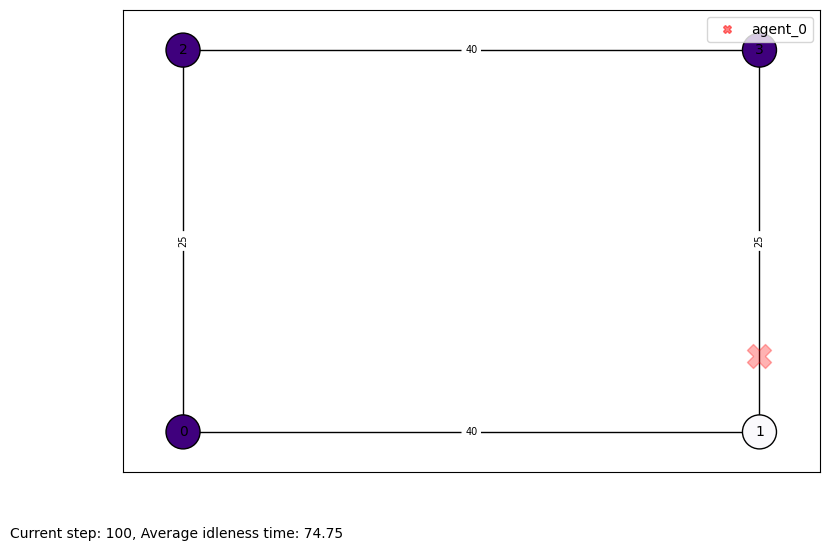

In [11]:
algo.evaluate(render=True, max_cycles=100, seed=42)